In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import scipy.optimize as sco

plt.style.use('fivethirtyeight')

In [2]:
import yfinance as yf

# Definir as ações do portfólio
#stocks = ['PETR4.SA','VALE3.SA','BBAS3.SA','EGIE3.SA']
#stocks = ['AAPL','NVDA','TSM','EA']
#stocks = ['AAPL', 'AMD', 'GOOG', 'TSM']
#stocks = ['TRPL4.SA', 'BBSE3.SA', 'ITUB3.SA', 'VIVT3.SA','VALE3.SA','CPFE3.SA','VLID3.SA','VBBR3.SA','EGIE3.SA','NEOE3.SA']
stocks = ['CVX','MCD','KO','PEP']

# Baixar apenas o preço de fechamento das ações para o intervalo especificado
data = yf.download(stocks, start="2010-10-21", end="2024-10-21")['Close']

# Mostrar os primeiros dados
data.tail()


[*********************100%%**********************]  4 of 4 completed


,CVX,KO,MCD,PEP
Date,,,,
2024-10-14,151.779999,70.339996,309.839996,176.100006
2024-10-15,147.729996,70.339996,313.339996,175.899994
2024-10-16,148.729996,70.570000,312.920013,174.479996
2024-10-17,151.199997,69.900002,314.700012,174.669998
2024-10-18,150.750000,70.440002,316.559998,175.059998


Text(0, 0.5, 'Price in $')

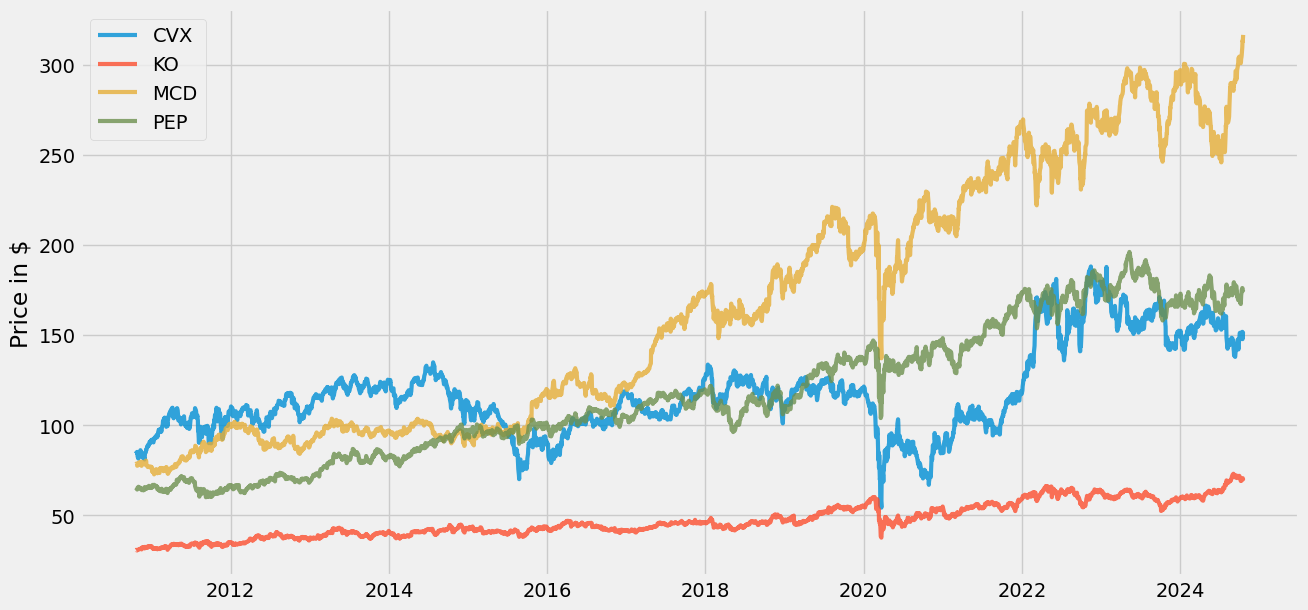

In [3]:
plt.figure(figsize=(14,7))
for c in data.columns.values:
    plt.plot(data.index,data[c],lw=3,alpha=0.8,label=c)
plt.legend()
plt.ylabel('Price in $')

Price data is good, but with a wide range it does not provide much value. Lets create a table of percentage changes. A logarithmic table could be used for analysis as well.

Text(0, 0.5, 'Daily Returns')

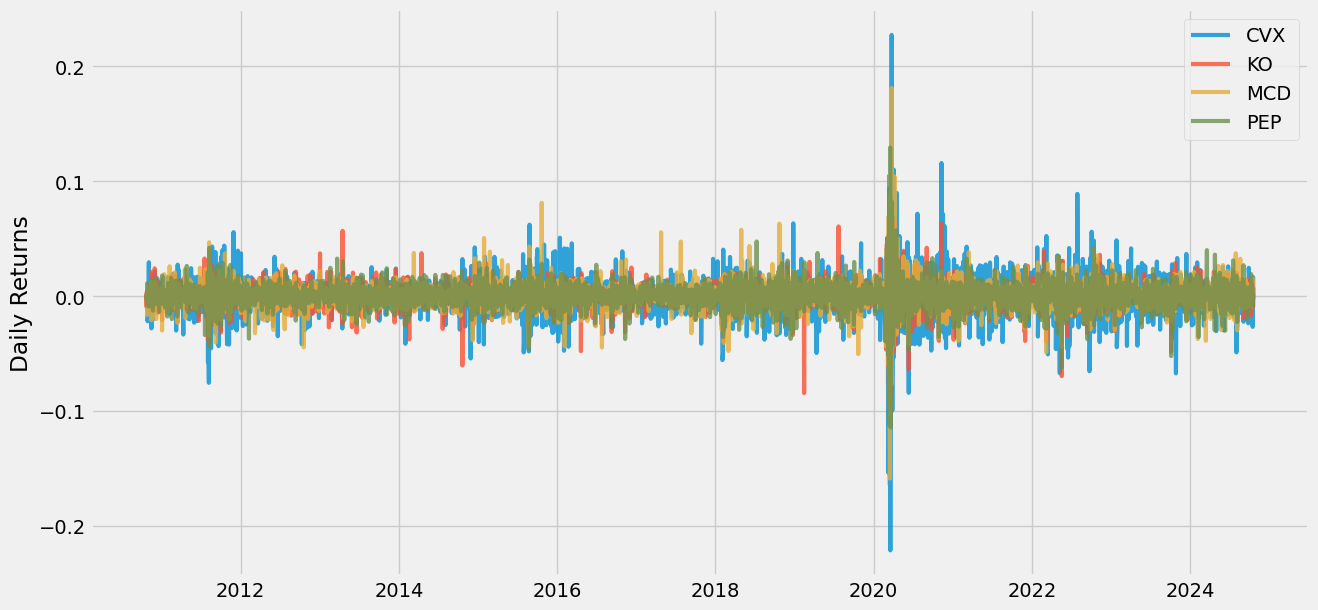

In [4]:
returns = data.pct_change()

plt.figure(figsize=(14,7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c],lw=3,alpha = 0.8, label = c)
plt.legend()
plt.ylabel('Daily Returns')

The Following code is to generate randomly weighted portifolios to plot and measure Sharp Ratios. If thousands of portifolios are generated, we should get very close to an optmized portifolio.

The Following code takes the sum od mean returns generated by the stocks for some average year (252 days). It then calculate the standard deviation of each portifolio.

In [5]:
def portifolio_annualised_performance(weights,mean_returns,cov_matrix):
    returns = np.sum(mean_returns*weights) *252
    std = np.sqrt(np.dot(weights.T,np.dot(cov_matrix,weights))) * np.sqrt(252)
    return std, returns

In [6]:
def random_portifolios(num_portifolios,mean_returns,cov_matrix,risk_free_rate):
    results = np.zeros((3,num_portifolios))
    weights_record = []
    for i in range(num_portifolios):
        weights = np.random.random(len(mean_returns))
        weights /=np.sum(weights)
        weights_record.append(weights)
        portifolio_std_dev, portifolio_return = portifolio_annualised_performance(weights,mean_returns,cov_matrix)
        results[0,i] = portifolio_std_dev
        results[1,i] = portifolio_return
        results[2,i] = (portifolio_return - risk_free_rate) / portifolio_std_dev
    return results, weights_record
        

In [7]:
#inputs
reutns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portifolios = 15000
risk_free_rate = 0.0178

Bellow is the code needed to calculate the returns, standard deviation, volatilitu and sharp ratio of the generated portifolios. There are print statements to display the portifolios with the maximum sharp ratio and it's anual return as well as the portifolios with the minimum volatility and its annual return. There is also a command to display the graph of the generated portifolios and the portifolio allovations.

In [8]:
def display_simulated_ef_with_radom(mean_returns,cov_matrix,num_portifolios,risk_free_rate):
    results, weights = random_portifolios(num_portifolios,mean_returns,cov_matrix,risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp ,rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index = data.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index = data.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portifolio Allocation")
    print("Annualised Return: ", round(rp,2))
    print("Annualised Volatility: ", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    
    print("-"*80)
    print("Minimum Volatility Portifolio Allocation")
    print("Annualised Return: ", round(rp_min,2))
    print("Annualised Volatility: ", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10,7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu',marker='o',s=10,alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500,label ='Maximum Sharpe Ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500,label ='Minimum Volatility')
    plt.title('Simulated Portifolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised retuns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portifolio Allocation
Annualised Return:  0.11
Annualised Volatility:  0.16


             CVX    KO    MCD    PEP
allocation  0.82  0.01  64.81  34.36
--------------------------------------------------------------------------------
Minimum Volatility Portifolio Allocation
Annualised Return:  0.09
Annualised Volatility:  0.15


             CVX     KO    MCD    PEP
allocation  6.33  31.03  30.08  32.56


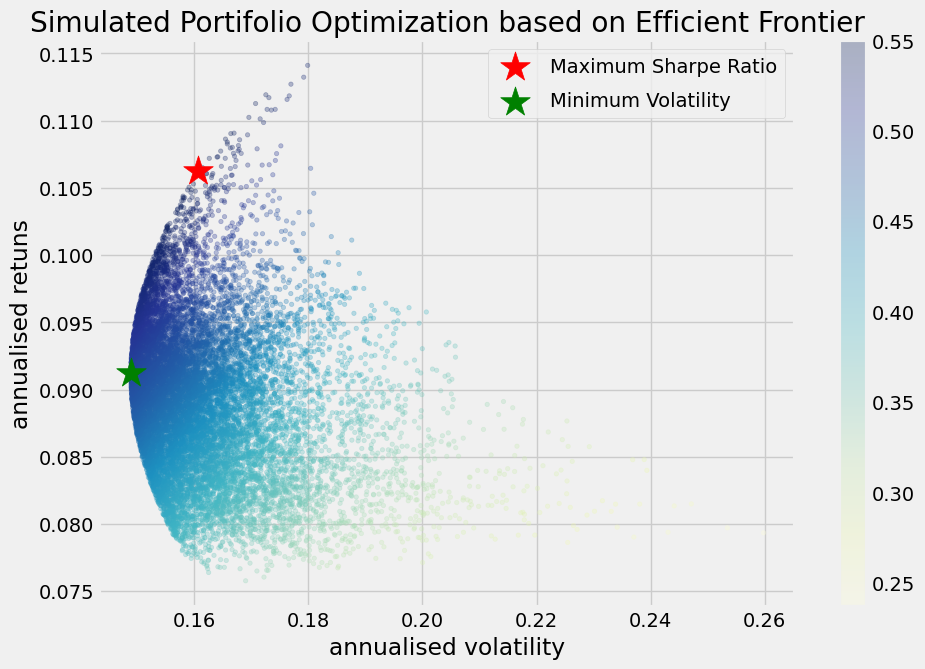

In [9]:
display_simulated_ef_with_radom(mean_returns,cov_matrix,num_portifolios,risk_free_rate)